In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate

## System of Equations

The equations of structure of an compact object with spherical symmetry (neutron stars in our case) is given by (in units where $c=G=1$):

$$ P=P(\rho), $$
$$ \frac{dm}{dr}=4\pi \rho r^2 , $$
$$ \frac{dP}{dr}=-(\rho+P)\frac{m+4\pi r^3 P}{r(r-2m)} , $$

and if is required


$$ \frac{d\nu}{dr}= \frac{m+4\pi r^3 P}{r(r-2m)} .$$


Nondimensionalizing the variables:


$r=b\bar{r} \quad ; \quad \rho=\Sigma \bar{\rho} \quad ; \quad m=m_*\bar{m} \quad ; \quad  P=P_* \bar{P}$ 

with $\Sigma=\Sigma(m_n)$.

So if we want just one parameter ($m_n$), given $\Sigma$, the other parameters $b$, $m_*$, $P_*$ are found by forcing the nondimensional equation to keep the same form:

$$ b=\frac{1}{\sqrt{\Sigma}} \quad ; \quad m_*=b \quad ; \quad P_*=\Sigma.$$

With a particular choice of $\Sigma$ and fixing the units with factors of $c$ and $G$ we have:


$$ \Sigma=\frac{m_{n}^{4}c^{3}}{8 \pi^2 \hbar^3}\quad;\quad b=\frac{c}{\sqrt{\Sigma G}}\quad, \quad m= \frac{b c^2}{G} \bar{m} \quad; \quad P= \Sigma c^2 \bar{P},$$

and the nondimensional system of equations keeps the same form:

$$ \bar{P}=\bar{P}(\bar{\rho}), $$
$$ \frac{d\bar{m}}{\bar{dr}}=4\pi \bar{\rho} \bar{r}^2 , $$
$$ \frac{d\bar{P}}{d\bar{r}}=-(\bar{\rho}+\bar{P})\frac{\bar{m}+4\pi \bar{r}^3 \bar{P}}{\bar{r}(\bar{r}-2\bar{m})} . $$

## Solving the system

To solve this system of equations we need two initial conditions:

$$ \bar{P}{(0)}=P_{c}{(\bar{\rho_{c}})} \quad ; \quad \bar{m}{(0)}=0,$$

depending on the choice of $\rho_{c}$.

We want our equation of state to be a table of numbers $(\rho_{i},P_{i})$, this equation of state will depend on the theoretical model used to study the interior of the neutron star.

Loading some constants (in cgs units) from a separeted file and declaring the parameters

In [6]:
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


Sigma=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0)
br=c/np.sqrt(Sigma*G) 
Mdim=(br*c**2.0/G)/Msun # So that m is measured in Solar masses

In [7]:
print(Sigma)

2280831545249651.0


and loading the equation of state and interpolating it linearly

In [8]:
rhoEoS,PEoS=np.loadtxt('EOSFull_NL3_BPS02.dat',usecols=(0,1),unpack=True) 

# Interpolating P
EoS_NL302=interpolate.interp1d(rhoEoS/Sigma,PEoS/(c**2.0*Sigma)) 


# Interpolating Rho
EoS_NL3=interpolate.interp1d(PEoS/(c**2.0*Sigma),rhoEoS/Sigma)

def rho_EoS(x):
    rhorho=interpolate.interp1d(PEoS/(c**2.0*Sigma),rhoEoS/Sigma)
    return rhorho(x)


def f(x):
    return 2*rho_EoS(x)

In [9]:
f(110.0)

231.93824520986823

Comparing the table and the interpolation

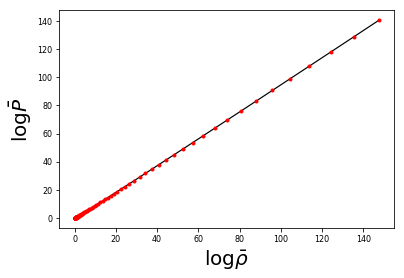

In [10]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(rhoEoS/Sigma,EoS_NL302(rhoEoS/Sigma),'k-', \
           linewidth=1.2,label="Interpolation") # Interpolación
plt.plot(rhoEoS/Sigma,PEoS/(c**2*Sigma),'ro', \
           markersize=3,label='Data') # Valores de la tabla
plt.xlabel(r'$\log\bar{\rho}$')
plt.ylabel(r'$\log\bar{P}$')
plt.savefig('NL3EoS.png', format='png', dpi=1000)
#plt.savefig('NL3EoS.eps')
plt.show()
plt.clf()

With the equation of state interpolated we can declare the system of equations:

In [16]:
def TOV(r,y,):
    mns = y[0]
    pns = y[1]
    nuns= y[2]
   # print(rho_EoS(pns))
    dmdr=4.0*np.pi*r**2.0*rho_EoS(pns)
    dnudr=(4.0*np.pi*r**3.0*pns+mns)/(r*(r-2.0*mns))
    dpdr=-dnudr*(pns+rho_EoS(pns))
    return [dmdr,dpdr,dnudr]

# Stellar structure

Setting up the integration routine

In [17]:
def StaticSeqSS(y0,r0,rf,dr):
    Static=integrate.ode(TOV).set_integrator('dopri5',atol=1e-9) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,r0)
    mms=[]; pexs=[];rs=[]
    mms.append(y0[0]*Mdim); pexs.append(y0[1]*c**2*Sigma); rs.append(r0*br)
    while Static.successful() and Static.t<rf and \
        EoS_NL3(Static.y[1])*Sigma>1e8 and Static.y[1]>0.0: #A condition over the density is included to stop the integration when P doesn't hit zero exactly
        Static.integrate(Static.t+dr)
        mms.append(Mdim*Static.y[0]);pexs.append(Static.y[1]); rs.append(Static.t)
    while Static.successful() and Static.t<rf and \
        EoS_NL3(Static.y[1])*Sigma>1e6 and Static.y[1]>0.0: # A refinement of the integration 
        Static.integrate(Static.t+dr/10.0) # Make step size smaller
        mms.append(Static.y[0]*Mdim);pexs.append(Static.y[1]*c**2*Sigma); rs.append(Static.t*br)
        mstar=Static.y[0]
        rstar=Static.t
        nustar=np.log(1-2.0*Static.y[0]/Static.t)-Static.y[2]  
    return [mstar*Mdim,rstar*br*1e-5,mms,pexs,rs] 
    # Returns mass of the star in solar masses, radius of the star in km, m(r) in solar masses, P(r) and r in cgs

# Mass-Radius relation

Setting up the integration routine (without saving the arrays)

In [33]:
def StaticSeqMR(y0,r0,rf,dr):
    Static=integrate.ode(TOV).set_integrator('dopri5',atol=1e-9) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,r0)
    while Static.successful() and Static.t<rf and Static.y[1]>1e-9:
         #A condition over the density is included to stop the integration when P doesn't hit zero exactly
        #print(Static.y[1])
        Static.integrate(Static.t+dr)
    mstar=Static.y[0]
    rstar=Static.t
    nustar=np.log(1-2.0*Static.y[0]/Static.t)-Static.y[2]  
    return [mstar*Mdim,rstar*br*1e-5] 
    # Returns mass of the star in solar masses and radius of the star in km

We choose the values for $\rho_c$ we want to consider and integrate from $r0$ to $rf$ every $dr$ saving the different values of $M_{star}$ y $R_{star}$ (slow):

In [34]:
#Initial values
dr1=1e-4 # Step size
r01=dr1/1000.0 # Initial point
rf1=2.0 # Final point
rhoc=np.arange(14.1,15.5,0.05)
xc=EoS_NL302((10.0**rhoc)/Sigma) 

In [35]:
MM=[];RR=[]

for xcc in xc:
    MR=StaticSeqMR([0,xcc,0],r01,rf1,dr1)
    print(MR)
    RR=RR+[MR[1]]
    MM=MM+[MR[0]]

[0.12529211987257946, 24.23781654012029]
[0.15775857954446254, 19.721785792475682]
[0.20019485578738835, 17.385991632902773]
[0.2532012157653049, 16.105072255072468]
[0.3169729812985362, 15.390479660988769]
[0.389738107924965, 14.991863384016908]
[0.4741307960340389, 14.7633882008745]
[0.5738851487553338, 14.634567086975059]
[0.693409346462873, 14.57137182355269]
[0.8417110017061366, 14.554357714169743]
[1.026362105577993, 14.57866358471681]
[1.2561955673172416, 14.629705912865644]
[1.5229861587295734, 14.692901176288013]
[1.802508352221364, 14.731790569163316]
[2.0662029486368008, 14.719637633889784]
[2.2896492502906636, 14.649150609303298]
[2.465651236046872, 14.527621256567974]
[2.596556912610844, 14.362341336847933]
[2.6888793702343032, 14.172755546580829]
[2.7499245765910416, 13.963725059876076]
[2.786305480004374, 13.747402812007198]
[2.8035118581166913, 13.526219390028912]
[2.8058982181950975, 13.305035968050623]
[2.7968950786175744, 13.086283133127042]
[2.7791940906607486, 12.8

Finally we plot the M-R relation

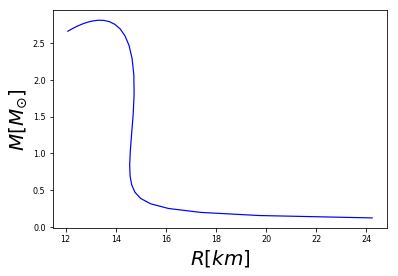

In [36]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(RR, MM,'b-', linewidth=1.2) 
plt.xlabel(r'$R [km]$')
plt.ylabel(r'$M [M_{\odot}]$')
plt.savefig('MRrel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

In [32]:
StaticSeqMR([0,110.1,0],r01,rf1,dr1)

[2.0732739527146893, 10.949797112040072]